# Multi-label classification using `AutoGluon`

- https://auto.gluon.ai/stable/index.html
- [Documentation - Text Prediction - Customisation](https://auto.gluon.ai/stable/tutorials/text_prediction/customization.html)

## (0) Import libraries

In [ ]:
#!pip install autogluon

In [1]:
import numpy as np
import pandas as pd
import warnings
import os
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
np.random.seed(123)

## (1) Data preparation

In [56]:
df = pd.read_csv('data/raw_train_test_data.csv')
df.drop(df.columns[0],axis=1,inplace=True)
df.head()

,Case Details,Category,Subcategory,Sector,Tag
0,PoC called to report a complaint that the teac...,Access,Cost of services,Education,Double
1,PoC called to report a complaint that the teac...,Service Quality Feedback,Poor quality service - staff/volunteers,Education,Double
2,PoC called to report a complaint that the teac...,Request for Assistance,New request,Education,Double
3,PoC called to report that parents have been to...,Access,Cost of services,Education,Double
4,PoC called to report that parents have been to...,Service Quality Feedback,Poor quality service - staff/volunteers,Education,Double


### `Sector`

In [57]:
df_sector = df.dropna(subset=['Sector'])
df_sector['Sector'] = df_sector['Sector'].replace(['Educaiton'],'Education')

In [58]:
df_sector = df_sector.drop(['Category', 'Subcategory', 'Tag'], axis=1)
df_sector.head()

,Case Details,Sector
0,PoC called to report a complaint that the teac...,Education
1,PoC called to report a complaint that the teac...,Education
2,PoC called to report a complaint that the teac...,Education
3,PoC called to report that parents have been to...,Education
4,PoC called to report that parents have been to...,Education


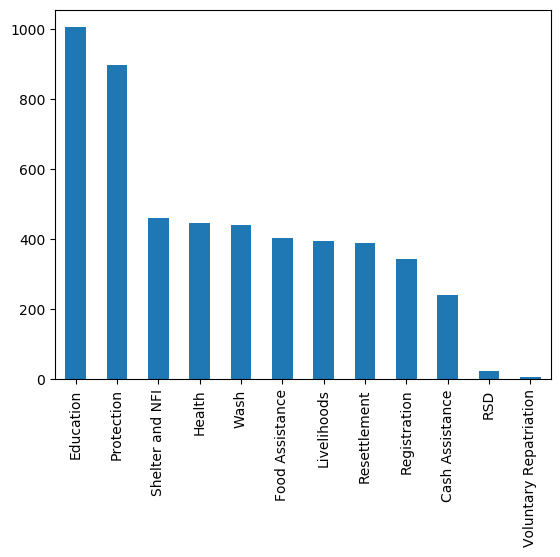

In [59]:
df_sector['Sector'].value_counts().plot.bar()
plt.show()

In [60]:
df_sector = df_sector.drop_duplicates(subset=['Case Details'])
df_sector['Sector'].value_counts().plot.bar()

In [61]:
df_sector.shape

(2645, 2)

In [62]:
# prepare for training
df_sector.columns = ['sentence','label']
df_sector = df_sector[['label','sentence']]
codes, uniques = pd.factorize(df_sector['label'])
df_sector['label'] = codes

# print labels and codes
for x,y in zip(df_sector['label'].unique(), uniques.values):
    print(f'{x} => "{y}"')
    
# save to disk
df_sector.to_csv('data/data_sector.csv', index=False)

0 => "Education"
1 => "Protection"
2 => "Registration"
3 => "Health"
4 => "Livelihoods"
5 => "Food Assistance"
6 => "Cash Assistance"
7 => "Wash"
8 => "Shelter and NFI"
9 => "Resettlement"
10 => "RSD"
11 => "Voluntary Repatriation"


### `Category`

In [73]:
df_category = df.dropna(subset=['Category'])

In [74]:
df_category = df_category.drop(['Sector', 'Subcategory', 'Tag'], axis=1)
df_category.head()

,Case Details,Category
0,PoC called to report a complaint that the teac...,Access
1,PoC called to report a complaint that the teac...,Service Quality Feedback
2,PoC called to report a complaint that the teac...,Request for Assistance
3,PoC called to report that parents have been to...,Access
4,PoC called to report that parents have been to...,Service Quality Feedback


In [75]:
df_category.Category.value_counts()

Request for Assistance                                 2879
Service Quality Feedback                                696
Access                                                  515
Request for Information                                 448
Documentation                                           314
Reporting Fraud/Misconduct/Discrimination/Incidents     207
Name: Category, dtype: int64

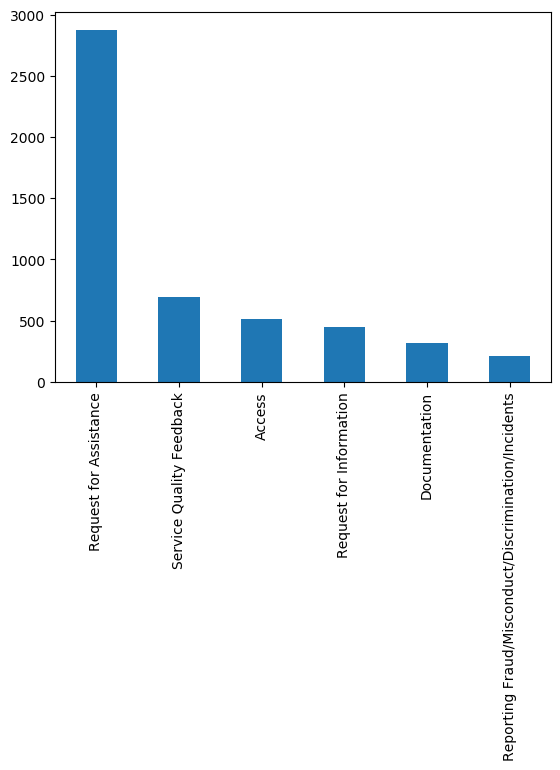

In [76]:
df_category['Category'].value_counts().plot.bar()
plt.show()

In [77]:
df_category=df_category.pivot_table(index='Case Details', columns=['Category'], aggfunc=len,fill_value=0)

In [79]:
df_category['sentence'] = df_category.index
df_category.reset_index(drop=True, inplace=True)
df_category= df_category.rename(columns=str.lower)
df_category.shape
df_category.head()

Category,access,documentation,reporting fraud/misconduct/discrimination/incidents,request for assistance,request for information,service quality feedback,sentence
0,0,1,0,0,0,0,A PoC says she got a massage yesterday in he m...
1,0,1,0,0,0,0,A PoC says she got a massage yesterday in he m...
2,1,1,0,0,0,0,A PoC says that she was settled in Base Camp a...
3,0,0,0,1,0,0,"According to this case 305461, the response sa..."
4,0,0,0,0,1,0,As per the feedback for the previous case that...


In [80]:
# save to disk
df_category.to_csv('data/data_category.csv', index=False)

### `Sub-category`

In [105]:
df_subcategory = df.dropna(subset=['Subcategory'])
df_subcategory = df_subcategory.drop(['Sector', 'Tag'], axis=1)
df_subcategory.head()

,Case Details,Category,Subcategory
0,"PoC called to report a complaint that the teachers of bright light primary school have been on strike since February 2020 and stopped teaching, the school is funded by UNHCR and Windle trust, PoC reports that the school administration is telling parents of Pupils to increase their money (school fees) to 10000 shillings, and this money will allow the teachers to teach properly and also increase the number of teachers in school for proper performance, there is PTA meeting scheduled on Friday 6th March 2020. PoC is requesting UNHCR to intervene in the matter and get a solution as most parent...",Access,Cost of services
1,"PoC called to report a complaint that the teachers of bright light primary school have been on strike since February 2020 and stopped teaching, the school is funded by UNHCR and Windle trust, PoC reports that the school administration is telling parents of Pupils to increase their money (school fees) to 10000 shillings, and this money will allow the teachers to teach properly and also increase the number of teachers in school for proper performance, there is PTA meeting scheduled on Friday 6th March 2020. PoC is requesting UNHCR to intervene in the matter and get a solution as most parent...",Service Quality Feedback,Poor quality service - staff/volunteers
2,"PoC called to report a complaint that the teachers of bright light primary school have been on strike since February 2020 and stopped teaching, the school is funded by UNHCR and Windle trust, PoC reports that the school administration is telling parents of Pupils to increase their money (school fees) to 10000 shillings, and this money will allow the teachers to teach properly and also increase the number of teachers in school for proper performance, there is PTA meeting scheduled on Friday 6th March 2020. PoC is requesting UNHCR to intervene in the matter and get a solution as most parent...",Request for Assistance,New request
3,"PoC called to report that parents have been told to pay shillings 20,000 for constructing the teachers quators by the headteacher of Ematong primary school, yet.PTA have been collecting money 7000 shillings every term. And also on top asking parents to pay that amount (20000), pupils were again forced to go and collect bricks from the community hence some pupils got caught for trying to steal bricks, PoC suggests Windle trust to visit the school and talk to the headteacher regarding this matter.",Access,Cost of services
4,"PoC called to report that parents have been told to pay shillings 20,000 for constructing the teachers quators by the headteacher of Ematong primary school, yet.PTA have been collecting money 7000 shillings every term. And also on top asking parents to pay that amount (20000), pupils were again forced to go and collect bricks from the community hence some pupils got caught for trying to steal bricks, PoC suggests Windle trust to visit the school and talk to the headteacher regarding this matter.",Service Quality Feedback,Poor quality service - staff/volunteers


In [106]:
df_subcategory.Subcategory.value_counts()

New request                                        1959
Legal/Physical Protection                           473
Follow up from previous request                     450
Information request                                 396
Delayed, missed, refused or reduced assistance      342
Cost of services                                    284
Poor quality service - goods and infrastructure     236
Legalizations, verifications, attestations          126
Change in implementing Partner                       93
Eligibility                                          91
Update existing documentation                        76
Physical access                                      74
Labour Dispute                                       64
Lack of Documentation                                48
Dispute over land                                    35
Coverage                                             34
Rumors Misinformation                                27
Theft                                           

In [107]:
df_subcategory=df_subcategory.pivot_table(index=['Case Details', 'Category'], columns='Subcategory', aggfunc=len,fill_value=0)
df_subcategory.head()

Subcategory                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Card broken or de-activated  \
Case Details                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Category                                              
A PoC says she got a massage yesterday in he mobile from UNHCR saying that UNHCR is looking the people who registered in Kampala to get their ID, phone number because some people are unregistered, so they are suppose to call FRRM for inquiry. she called to get more information.                                                                                                                                                                                                                                                                                                                                   Documentation                                     0   
A PoC says she got a massage yesterday in he mobile from UNHCR saying that UNHCR is looking the people who registered in Kampala to get their ID, phone number because some people are unregistered, so they are suppose to call FRRM for inquiry. she called to get more information. her ID (PNK- 00038850), phone (0795091014).                                                                                                                                                                                                                                                                                       Documentation                                     0   
A PoC says that she was settled in Base Camp after having been transferred from Karaganda and she was given new documents with a new Family attestation which was was changed the change of date of arrival from 2012 to 2018. Based on this, they refused to give her the money for this month at the office where they are supposed to get their Money "those in the CPI Program" PoC has been told she couldn't be helped because she has been in the settlement for a short while which isn't true. She would like to know who to approach for assistance about this issue.                                          Access                                            0   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Documentation                                     0   
According to this case 305461, the response says that the POC sh

In [108]:
df_subcategory['sentence'] = df_subcategory.index.get_level_values('Case Details')
df_subcategory['category'] = df_subcategory.index.get_level_values('Category')
df_subcategory= df_subcategory.rename(columns=str.lower)
df_subcategory.reset_index(drop=True, inplace=True)
df_subcategory.shape

(3222, 31)

In [109]:
df_subcategory.head()

Subcategory,card broken or de-activated,certificate/document request,change in implementing partner,corruption or bribery,cost of services,coverage,"delayed, missed, refused or reduced assistance",discrimination of poc,dispute over land,documentation stolen or lost,...,misconduct,new request,physical access,poor quality service - goods and infrastructure,poor quality service - staff/volunteers,rumors misinformation,theft,update existing documentation,sentence,category
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"A PoC says she got a massage yesterday in he mobile from UNHCR saying that UNHCR is looking the people who registered in Kampala to get their ID, phone number because some people are unregistered, so they are suppose to call FRRM for inquiry. she called to get more information.",Documentation
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"A PoC says she got a massage yesterday in he mobile from UNHCR saying that UNHCR is looking the people who registered in Kampala to get their ID, phone number because some people are unregistered, so they are suppose to call FRRM for inquiry. she called to get more information. her ID (PNK- 00038850), phone (0795091014).",Documentation
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"A PoC says that she was settled in Base Camp after having been transferred from Karaganda and she was given new documents with a new Family attestation which was was changed the change of date of arrival from 2012 to 2018. Based on this, they refused to give her the money for this month at the office where they are supposed to get their Money ""those in the CPI Program"" PoC has been told she couldn't be helped because she has been in the settlement for a short while which isn't true. She would like to know who to approach for assistance about this issue.",Access
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"A PoC says that she was settled in Base Camp after having been transferred from Karaganda and she was given new documents with a new Family attestation which was was changed the change of date of arrival from 2012 to 2018. Based on this, they refused to give her the money for this month at the office where they are supposed to get their Money ""those in the CPI Program"" PoC has been told she couldn't be helped because she has been in the settlement for a short while which isn't true. She would like to know who to approach for assistance about this issue.",Documentation
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"According to this case 305461, the response says that the POC should go to the health facility (rubondo) to get the medicine and when the wife went there on 01/22/2020 she was abused by nurses saying that if they do not stop following up on this they will have problems because the owner of this dog works for one of the nurses and thereafter one of the staff came following this woman and he stopped at their door and turned back and this is how it starts to start mistreating people whom they violate by knowing the home by sending people to see the home, it has happened several times to many ...",Request for Assistance


In [110]:
df_subcategory.to_csv('data/data_subcategory.csv',index=False)

## (2) Model training (`Sector`)

### Approach A: Using `TabularPredictor`
- https://auto.gluon.ai/scoredebugweight/api/autogluon.task.html#autogluon.tabular.TabularPredictor

In [23]:
from autogluon.tabular import TabularPredictor
time_limit = 1 * 60 * 60
pred_sector = TabularPredictor(label='label', path='pred_sector')
pred_sector.fit(df_sector, hyperparameters='multimodal', time_limit=time_limit)

Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "pred_sector/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    2645
Train Data Columns: 1
Label Column: label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	First 10 (of 12) unique label values:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Fraction of data from classes with at least 10 examples that will be kept for training models: 0.9973534971644612
Train Data Class Count: 11
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1933.23 MB
	Train Data (Original)  Memory Usage: 0

[1000]	valid_set's multi_error: 0.236473


	0.7655	 = Validation score   (accuracy)
	36.12s	 = Training   runtime
	0.69s	 = Validation runtime
Fitting model: TextPredictor ... Training model for up to 3371.68s of the 3371.67s of remaining time.
		Model requires 1 num_gpus to fit, but 0 are available.
Detailed Traceback:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/autogluon/core/trainer/abstract_trainer.py", line 1126, in _train_and_save
    model = self._train_single(X, y, model, X_val, y_val, **model_fit_kwargs)
  File "/opt/conda/lib/python3.7/site-packages/autogluon/core/trainer/abstract_trainer.py", line 1083, in _train_single
    model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, **model_fit_kwargs)
  File "/opt/conda/lib/python3.7/site-packages/autogluon/core/models/abstract/abstract_model.py", line 585, in fit
    self.validate_fit_resources(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/autogluon/core/models/abstract/abstract_model.py", line 1142, in validate_fit_resour

In [24]:
leaderboard = pred_sector.leaderboard(df_sector)
leaderboard.to_csv('data/leaderboard.csv',index=False)
leaderboard.head()

                 model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2    0.956522   0.785571        0.574883       0.077986   22.681457                 0.005527                0.000544           0.334563            2       True          7
1             LightGBM    0.956144   0.783567        0.280597       0.042643   11.520077                 0.280597                0.042643          11.520077            1       True          1
2              XGBoost    0.953875   0.769539        0.387347       0.050801   16.072620                 0.387347                0.050801          16.072620            1       True          4
3        LightGBMLarge    0.953119   0.765531        2.471113       0.689528   36.116277                 2.471113                0.689528          36.116277            1       True          6
4           LightGBMXT    0.947448   0.7

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.956522,0.785571,0.574883,0.077986,22.681457,0.005527,0.000544,0.334563,2,True,7
1,LightGBM,0.956144,0.783567,0.280597,0.042643,11.520077,0.280597,0.042643,11.520077,1,True,1
2,XGBoost,0.953875,0.769539,0.387347,0.050801,16.072620,0.387347,0.050801,16.072620,1,True,4
3,LightGBMLarge,0.953119,0.765531,2.471113,0.689528,36.116277,2.471113,0.689528,36.116277,1,True,6
4,LightGBMXT,0.947448,0.781563,0.288759,0.034799,10.826816,0.288759,0.034799,10.826816,1,True,2


### (Optional) Use `StackEnsemble`
- https://auto.gluon.ai/stable/tutorials/tabular_prediction/tabular-multimodal-text-others.html#improve-the-performance-with-stack-ensemble

In [ ]:
# time_limit = 1 * 60 * 60
# pred_sector_ensemble = TabularPredictor(label='Sector', path='predict_sector_stack_ensemble')
# pred_sector_ensemble.fit(df_sector, hyperparameters='multimodal', presets='best_quality', time_limit=time_limit)

## Approach B: Using `TextPredictor`
- https://auto.gluon.ai/stable/tutorials/tabular_prediction/tabular-multimodal-text-others.html#improve-the-performance-with-stack-ensemble
- https://auto.gluon.ai/stable/tutorials/text_prediction/customization.html

`TextPredictor` provides several simple preset configurations. Let’s take a look at the available presets.

In [25]:
from autogluon.text.text_prediction.presets import list_text_presets
list_text_presets(verbose=True)

{'default': {'model.hf_text.checkpoint_name': 'google/electra-base-discriminator'},
 'medium_quality_faster_train': {'model.hf_text.checkpoint_name': 'google/electra-small-discriminator',
  'optimization.learning_rate': 0.0004},
 'high_quality': {'model.hf_text.checkpoint_name': 'google/electra-base-discriminator'},
 'best_quality': {'model.hf_text.checkpoint_name': 'microsoft/deberta-v3-base',
  'env.per_gpu_batch_size': 2},
 'multilingual': {'model.hf_text.checkpoint_name': 'microsoft/mdeberta-v3-base',
  'optimization.top_k': 1,
  'env.precision': 'bf16',
  'env.per_gpu_batch_size': 4}}

In [26]:
# split train/test data
train_data = df_sector.sample(frac=0.9, random_state=42)
test_data = df_sector.drop(train_data.index)
label = "label"
y_test = test_data[label]
X_test = test_data.drop(columns=[label])

In [27]:
print(train_data.shape)
print(test_data.shape)

(2380, 2)
(265, 2)


### Model training

In [ ]:
from autogluon.text import TextPredictor
time_limit = 1 * 60 * 60
pred_sector_textpred = TextPredictor(eval_metric="acc", label="label")
pred_sector_textpred.fit(
    train_data=train_data,
    presets="medium_quality_faster_train",
    time_limit=time_limit,
)

### Evaluate against `test_data`

In [ ]:
pred_sector_textpred.evaluate(test_data, metrics=["f1", "acc"])

### Model inference against `validation` data

In [ ]:
validation_df = pd.read_excel('data/validation_set.xlsx')
val_data = validation_df.drop(columns=['Case Category','Gender','District'])
val_data.columns = ['sentence']

In [ ]:
output = pred_sector.predict(val_data)
output.head()

In [ ]:
output_df = val_data.copy()
output_df['predicted'] = output
output_df.head()

In [ ]:
output_df.to_csv('data/output.csv',index=False)

## (3) Model training (`Category`)

### Approach: Using `MultilabelPredictor`
https://auto.gluon.ai/stable/tutorials/tabular_prediction/tabular-multilabel.html#inference-and-evaluation

In [86]:
df_category = pd.read_csv('data/data_category.csv') 
category_train_data = df_category.sample(frac=0.9, random_state=42)

In [87]:
category_test_data = df_category.drop(category_train_data.index)
category_test_data.to_csv('data/category_test_data.csv', index=False)

In [88]:
print(category_train_data.shape)
print(category_test_data.shape)
category_train_data.head()

(2380, 7)
(265, 7)


,access,documentation,reporting fraud/misconduct/discrimination/incidents,request for assistance,request for information,service quality feedback,sentence
890,0,2,0,0,0,0,PoC called to report that she was registered w...
2404,1,0,0,0,1,1,The caller is a national and called to inquir...
1037,0,1,0,0,0,0,PoC is calling to report that he has a child w...
961,0,0,0,3,0,2,PoC called to that there is shortage of water ...
1480,1,0,0,2,0,0,PoC's children were registered under the schol...


In [96]:
from MultilabelPredictor import MultilabelPredictor

labels = [f'{x}' for x in category_train_data.columns]
labels.remove('sentence')
save_path='models'
cat_multi_predictor = MultilabelPredictor(labels=labels, path=save_path)
cat_multi_predictor.fit(category_train_data)

Beginning AutoGluon training ...
AutoGluon will save models to "models/Predictor_access/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    2380
Train Data Columns: 1
Label Column: access
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	6 unique label values:  [0, 1, 2, 3, 4, 5]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Fraction of data from classes with at least 10 examples that will be kept for training models: 0.9983193277310924
Train Data Class Count: 4
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1951.82 MB
	Train Data (Original)  Memory Usage: 0.9 MB (0.0% of available memory)
	

Fitting TabularPredictor for label: access ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1265
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('object', ['text']) : 1 | ['sentence']
	Types of features in processed data (raw dtype, special dtypes):
		('int', ['binned', 'text_special']) :   14 | ['sentence.char_count', 'sentence.word_count', 'sentence.capital_ratio', 'sentence.lower_ratio', 'sentence.digit_ratio', ...]
		('int', ['text_ngram'])             : 1266 | ['__nlp__.000', '__nlp__.000 ugx', '__nlp__.19',

Fitting TabularPredictor for label: documentation ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1262
		Reducing Vectorizer vocab size from 1262 to 433 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 1 | ['access']
		('object', ['text']) : 1 | ['sentence']
	Types of features in processed data (raw dtype, special dtypes):
		('int', [])                         :   1 | ['access']
		('int', ['binned', 'text_special']) :  14 | ['sentence.char_co

Fitting TabularPredictor for label: reporting fraud/misconduct/discrimination/incidents ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1259
		Reducing Vectorizer vocab size from 1259 to 391 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 2 | ['access', 'documentation']
		('object', ['text']) : 1 | ['sentence']
	Types of features in processed data (raw dtype, special dtypes):
		('int', [])                         :   2 | ['access', 'documentation']
		('int', ['binned', 'text_spe

Fitting TabularPredictor for label: request for assistance ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1258
		Reducing Vectorizer vocab size from 1258 to 395 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 3 | ['access', 'documentation', 'reporting fraud/misconduct/discrimination/incidents']
		('object', ['text']) : 1 | ['sentence']
	Types of features in processed data (raw dtype, special dtypes):
		('int', [])                         :   3 | ['a

Fitting TabularPredictor for label: request for information ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1258
		Reducing Vectorizer vocab size from 1258 to 354 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 4 | ['access', 'documentation', 'reporting fraud/misconduct/discrimination/incidents', 'request for assistance']
		('object', ['text']) : 1 | ['sentence']
	Types of features in processed data (raw dtype, special dtypes):
		('int', [])          

Fitting TabularPredictor for label: service quality feedback ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1260
		Reducing Vectorizer vocab size from 1260 to 341 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 5 | ['access', 'documentation', 'reporting fraud/misconduct/discrimination/incidents', 'request for assistance', 'request for information']
		('object', ['text']) : 1 | ['sentence']
	Types of features in processed data (raw dtype, special dtype

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('models/')


In [98]:
predictor_class = cat_multi_predictor.get_predictor('documentation')
predictor_class.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,0.936975,0.045840,2.798952,0.045840,2.798952,1,True,5
1,WeightedEnsemble_L2,0.936975,0.046272,3.212549,0.000432,0.413597,2,True,14
2,CatBoost,0.932773,0.010337,4.887029,0.010337,4.887029,1,True,8
3,XGBoost,0.930672,0.014278,2.400199,0.014278,2.400199,1,True,11
4,LightGBMXT,0.930672,0.021188,2.243260,0.021188,2.243260,1,True,4
5,LightGBMLarge,0.930672,0.075606,5.641281,0.075606,5.641281,1,True,13
6,RandomForestGini,0.918067,0.102849,1.580466,0.102849,1.580466,1,True,6
7,RandomForestEntr,0.915966,0.102992,1.551508,0.102992,1.551508,1,True,7
8,KNeighborsDist,0.915966,0.122099,0.050070,0.122099,0.050070,1,True,2
9,KNeighborsUnif,0.915966,0.122558,0.046638,0.122558,0.046638,1,True,1


### Model Inference and Evaluation using `validation data`

In [99]:
from autogluon.tabular import TabularDataset

category_test_data = TabularDataset('data/category_test_data.csv')
category_test_data_nolab = category_test_data.drop(columns=labels)  # unnecessary, just to demonstrate we're not cheating here
category_test_data_nolab.head()

Loaded data from: data/category_test_data.csv | Columns = 7 / 7 | Rows = 265 -> 265


,sentence
0,"A PoC says she got a massage yesterday in he mobile from UNHCR saying that UNHCR is looking the people who registered in Kampala to get their ID, phone number because some people are unregistered, so they are suppose to call FRRM for inquiry. she called to get more information. her ID (PNK- 00038850), phone (0795091014)."
1,He has a daughter of 7 years who is in primary school however he is unable to pay the development fees of the child since he doesn't work. He is requesting for support with paying the development fees of the child so as the daughter can also feel that the father cares about her being in school.
2,"He has children who came to visit him in Kyaka II from Nakivale where they were registered from. PoC says that due to the lockdown measure, they are not able to return to Nakivale, and now the little food that he receives monthly can't sustain them anymore. He is afraid that they will die with hunger and is requesting to be assisted."
3,He is a student at Yoyo at UACE and he passed with good results at A'level however he facing financial difficulties to support himself at school as he would like to upgrade to an institutional level or university. He was inquiring about scholarship support so as to join an institute or university.
4,He is reporting that he is an asylum seeker and the expiry date is done and he would like to know he can be assisted with the refugee status determination by the REC. He is requesting assistance with the refugee status determination.he has a language barrier in English.


In [100]:
predictions = cat_multi_predictor.predict(category_test_data_nolab)
print("Predictions:  \n", predictions)

Predicting with TabularPredictor for label: access ...
Predicting with TabularPredictor for label: documentation ...
Predicting with TabularPredictor for label: reporting fraud/misconduct/discrimination/incidents ...
Predicting with TabularPredictor for label: request for assistance ...
Predicting with TabularPredictor for label: request for information ...
Predicting with TabularPredictor for label: service quality feedback ...
Predictions:  
      access  documentation  \
0         0              1   
1         1              0   
2         0              2   
3         0              0   
4         0              0   
..      ...            ...   
260       0              0   
261       0              0   
262       0              0   
263       0              0   
264       0              0   

     reporting fraud/misconduct/discrimination/incidents  \
0                                                      0   
1                                                      0   
2         

In [103]:
output_cat_df = category_test_data_nolab.copy()
cat_result = pd.concat([output_cat_df, predictions], axis=1).reindex(output_cat_df.index)
cat_result.head()
cat_result.to_csv('data/cat_output.csv',index=False)

In [104]:
evaluations = cat_multi_predictor.evaluate(category_test_data)
print(evaluations)
print("Evaluated using metrics:", cat_multi_predictor.eval_metrics)

Evaluating TabularPredictor for label: access ...


Evaluation: accuracy on test data: 0.8377358490566038
Evaluations on test data:
{
    "accuracy": 0.8377358490566038,
    "balanced_accuracy": 0.3194762996941899,
    "mcc": 0.31731120956394765
}


Evaluating TabularPredictor for label: documentation ...


Evaluation: accuracy on test data: 0.9245283018867925
Evaluations on test data:
{
    "accuracy": 0.9245283018867925,
    "balanced_accuracy": 0.453150112504018,
    "mcc": 0.2738108159794907
}
Evaluation: accuracy on test data: 0.9320754716981132
Evaluations on test data:
{
    "accuracy": 0.9320754716981132,
    "balanced_accuracy": 0.24899193548387138,
    "mcc": -0.014615878872254733
}


Evaluating TabularPredictor for label: reporting fraud/misconduct/discrimination/incidents ...


Evaluation: accuracy on test data: 0.5584905660377358
Evaluations on test data:
{
    "accuracy": 0.5584905660377358,
    "balanced_accuracy": 0.34691940240306124,
    "mcc": 0.35827857163372
}


Evaluating TabularPredictor for label: request for assistance ...
Evaluating TabularPredictor for label: request for information ...


Evaluation: accuracy on test data: 0.8490566037735849
Evaluations on test data:
{
    "accuracy": 0.8490566037735849,
    "balanced_accuracy": 0.3766266266266267,
    "mcc": 0.25982512167236954
}
Evaluation: accuracy on test data: 0.7660377358490567
Evaluations on test data:
{
    "accuracy": 0.7660377358490567,
    "balanced_accuracy": 0.2940614617940202,
    "mcc": 0.3469244822666703
}


Evaluating TabularPredictor for label: service quality feedback ...
{'access': {'accuracy': 0.8377358490566038, 'balanced_accuracy': 0.3194762996941899, 'mcc': 0.31731120956394765}, 'documentation': {'accuracy': 0.9245283018867925, 'balanced_accuracy': 0.453150112504018, 'mcc': 0.2738108159794907}, 'reporting fraud/misconduct/discrimination/incidents': {'accuracy': 0.9320754716981132, 'balanced_accuracy': 0.24899193548387138, 'mcc': -0.014615878872254733}, 'request for assistance': {'accuracy': 0.5584905660377358, 'balanced_accuracy': 0.34691940240306124, 'mcc': 0.35827857163372}, 'request for information': {'accuracy': 0.8490566037735849, 'balanced_accuracy': 0.3766266266266267, 'mcc': 0.25982512167236954}, 'service quality feedback': {'accuracy': 0.7660377358490567, 'balanced_accuracy': 0.2940614617940202, 'mcc': 0.3469244822666703}}
Evaluated using metrics: {'access': accuracy, 'documentation': accuracy, 'reporting fraud/misconduct/discrimination/incidents': accuracy, 'request for a

## (4) Model training (`Subcategory`)

In [111]:
df_subcategory = pd.read_csv('data/data_subcategory.csv')

subcategory_train_data = df_subcategory.sample(frac=0.9, random_state=44)
subcategory_test_data = df_subcategory.drop(subcategory_train_data.index)
subcategory_test_data.to_csv('data/subcategory_test_data.csv', index=False)

In [112]:
print(subcategory_train_data.shape)
print(subcategory_test_data.shape)

(2900, 31)
(322, 31)


In [114]:
from MultilabelPredictor import MultilabelPredictor

time_limit = 1200

labels = [f'{x}' for x in subcategory_train_data.columns]
labels.remove('sentence')
labels.remove('category')
metrics=['accuracy' for _ in range(29)]
problem_types=['multiclass' for _ in range(29)]
print(len(labels))
print(len(metrics))
save_path='models'
multi_predictor = MultilabelPredictor(labels=labels, path=save_path, eval_metrics=metrics, problem_types=problem_types)
multi_predictor.fit(subcategory_train_data, time_limit=time_limit)

29
29


Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "models/Predictor_card broken or de-activated/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    2900
Train Data Columns: 2
Label Column: card broken or de-activated
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Train Data Class Count: 2
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1540.82 MB
	Train Data (Original)  Memory Usage: 1.38 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.


Fitting TabularPredictor for label: card broken or de-activated ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1291
		Reducing Vectorizer vocab size from 1291 to 343 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('object', [])       : 1 | ['category']
		('object', ['text']) : 1 | ['sentence']
	Types of features in processed data (raw dtype, special dtypes):
		('category', [])                    :   1 | ['category']
		('category', ['text_as_category'])  :   1 | ['sentence']
		('int', ['binned', 'text_special']) :

Fitting TabularPredictor for label: certificate/document request ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1291
		Reducing Vectorizer vocab size from 1291 to 341 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 1 | ['card broken or de-activated']
		('object', [])       : 1 | ['category']
		('object', ['text']) : 1 | ['sentence']
	Types of features in processed data (

Fitting TabularPredictor for label: change in implementing partner ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1285
		Reducing Vectorizer vocab size from 1285 to 333 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 2 | ['card broken or de-activated', 'certificate/document request']
		('object', [])       : 1 | ['category']
		('object', ['text']) : 1 | ['sentence']
	Types

Fitting TabularPredictor for label: corruption or bribery ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1290
		Reducing Vectorizer vocab size from 1290 to 330 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 3 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner']
		('object', [])       : 1 | ['category']
		('object', [

Fitting TabularPredictor for label: cost of services ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1291
		Reducing Vectorizer vocab size from 1291 to 331 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 4 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery']
		('object', [])       : 1 | ['

Fitting TabularPredictor for label: coverage ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1291
		Reducing Vectorizer vocab size from 1291 to 321 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 5 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services']
		('object'

Fitting TabularPredictor for label: delayed, missed, refused or reduced assistance ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1287
		Reducing Vectorizer vocab size from 1287 to 321 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 6 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('ob

Fitting TabularPredictor for label: discrimination of poc ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1290
		Reducing Vectorizer vocab size from 1290 to 313 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 7 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('ob

Fitting TabularPredictor for label: dispute over land ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1289
		Reducing Vectorizer vocab size from 1289 to 313 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 8 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('ob

Fitting TabularPredictor for label: documentation stolen or lost ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1289
		Reducing Vectorizer vocab size from 1289 to 313 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 9 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('ob

Fitting TabularPredictor for label: eligibility ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1291
		Reducing Vectorizer vocab size from 1291 to 314 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 10 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: follow up from previous request ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1288
		Reducing Vectorizer vocab size from 1288 to 313 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 11 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: fraud ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1290
		Reducing Vectorizer vocab size from 1290 to 325 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 12 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: inadequate response from leaders/committees ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1289
		Reducing Vectorizer vocab size from 1289 to 325 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 13 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: incident/conflict ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1290
		Reducing Vectorizer vocab size from 1290 to 325 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 14 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: information request ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1290
		Reducing Vectorizer vocab size from 1290 to 325 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 15 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: labour dispute ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1285
		Reducing Vectorizer vocab size from 1285 to 320 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 16 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: lack of documentation ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1291
		Reducing Vectorizer vocab size from 1291 to 322 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 17 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: language barrier ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1291
		Reducing Vectorizer vocab size from 1291 to 322 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 18 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: legal/physical protection ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1278
		Reducing Vectorizer vocab size from 1278 to 318 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 19 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: legalizations, verifications, attestations ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1286
		Reducing Vectorizer vocab size from 1286 to 324 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 20 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: misconduct ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1291
		Reducing Vectorizer vocab size from 1291 to 325 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 21 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: new request ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1288
		Reducing Vectorizer vocab size from 1288 to 324 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 22 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: physical access ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1289
		Reducing Vectorizer vocab size from 1289 to 308 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 23 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: poor quality service - goods and infrastructure ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1288
		Reducing Vectorizer vocab size from 1288 to 303 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 24 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: poor quality service - staff/volunteers ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1290
		Reducing Vectorizer vocab size from 1290 to 302 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 25 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: rumors misinformation ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1290
		Reducing Vectorizer vocab size from 1290 to 319 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 26 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: theft ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1289
		Reducing Vectorizer vocab size from 1289 to 313 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 27 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

Fitting TabularPredictor for label: update existing documentation ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentence']
			CountVectorizer fit with vocabulary size = 1290
		Reducing Vectorizer vocab size from 1290 to 314 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 28 | ['card broken or de-activated', 'certificate/document request', 'change in implementing partner', 'corruption or bribery', 'cost of services', ...]
		('o

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('models/')


In [50]:
predictor_class = multi_predictor.get_predictor('label6')
predictor_class.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.983968,0.116198,2.820899,0.000665,0.386418,2,True,14
1,XGBoost,0.981964,0.010661,1.134567,0.010661,1.134567,1,True,11
2,LightGBMXT,0.979960,0.013755,1.620056,0.013755,1.620056,1,True,4
3,LightGBM,0.977956,0.043051,2.194048,0.043051,2.194048,1,True,5
4,CatBoost,0.975952,0.016353,5.999641,0.016353,5.999641,1,True,8
5,NeuralNetFastAI,0.975952,0.018361,2.703618,0.018361,2.703618,1,True,3
6,NeuralNetTorch,0.975952,0.019838,6.440510,0.019838,6.440510,1,True,12
7,LightGBMLarge,0.975952,0.028782,4.527091,0.028782,4.527091,1,True,13
8,RandomForestEntr,0.917836,0.105715,1.276413,0.105715,1.276413,1,True,7
9,RandomForestGini,0.915832,0.104872,1.299914,0.104872,1.299914,1,True,6


### Model Inference and Evaluation using `validation data`

In [115]:
from autogluon.tabular import TabularDataset

subcategory_test_data = TabularDataset('data/subcategory_test_data.csv')
subcategory_test_data_nolab = subcategory_test_data.drop(columns=labels)  # unnecessary, just to demonstrate we're not cheating here
subcategory_test_data_nolab.head()

Loaded data from: data/subcategory_test_data.csv | Columns = 31 / 31 | Rows = 322 -> 322


,sentence,category
0,"He called helpline from health center vi-Kisenyi about health condition going through.he was operated 4 times before but no improvement. PoC says he has a big wound on his leg and returned fresh plus seriously bleeding, he was in Mulago and Doctors sent him to AHA for health referral assistance. he presented medical reports to AHA in February 2020 from Mulago and was promised to be contacted, which he has been waiting for up to now. PoC says he is HIV positive and he doesn't have transport to take him back to AHA for the follow up on his medical case. again said he has been lining up at Ki...",Access
1,He did one interview with Angelique at the UNHCR office. He would like to get an update since he has never been contacted since the time he did that interview.,Request for Assistance
2,He gained skill of carpentry training and the lockdown of COVID-19 pandemic got him in Kampala. He is back to the settlement and when he arrived at the settlement but now his name has been deactivated in the system and he can't receive any cash assistance. He was told by OPM officer that his details will be activated in September yet he has family members are depending on him.he would like to be supported and his details can be activated in the system or the registration to be adjust so that he can receive cash assistance for August as september is far.,Access
3,He had a health problem and traveled to Kampala for treatment but lock down found him in Kampala now doesn't have ways of going back due to COVID 19 measures .now he is worried of his card to be deactivated because of missing food the second month.,Access
4,"He has a brother who was registered in Nakivale. But because the brother was alone there, he decided to call him to come to Kyaka since they didn't give him an official transfer from Nakivale to Kyaka. He is calling to request for assistance to transfer his brother's file to Kyaka so that he can start receiving assistance from Kyaka where he is.",Documentation


In [116]:
predictions = multi_predictor.predict(subcategory_test_data_nolab)
print("Predictions:  \n", predictions)

Predicting with TabularPredictor for label: card broken or de-activated ...
Predicting with TabularPredictor for label: certificate/document request ...
Predicting with TabularPredictor for label: change in implementing partner ...
Predicting with TabularPredictor for label: corruption or bribery ...
Predicting with TabularPredictor for label: cost of services ...
Predicting with TabularPredictor for label: coverage ...
Predicting with TabularPredictor for label: delayed, missed, refused or reduced assistance ...
Predicting with TabularPredictor for label: discrimination of poc ...
Predicting with TabularPredictor for label: dispute over land ...
Predicting with TabularPredictor for label: documentation stolen or lost ...
Predicting with TabularPredictor for label: eligibility ...
Predicting with TabularPredictor for label: follow up from previous request ...
Predicting with TabularPredictor for label: fraud ...
Predicting with TabularPredictor for label: inadequate response from leade

In [117]:
evaluations = multi_predictor.evaluate(subcategory_test_data)
print(evaluations)
print("Evaluated using metrics:", multi_predictor.eval_metrics)

Evaluation: accuracy on test data: 0.9968944099378882
Evaluations on test data:
{
    "accuracy": 0.9968944099378882,
    "balanced_accuracy": 0.9984375,
    "mcc": 0.8152198067597065
}


Evaluating TabularPredictor for label: card broken or de-activated ...
Evaluating TabularPredictor for label: certificate/document request ...


Evaluation: accuracy on test data: 0.9906832298136646
Evaluations on test data:
{
    "accuracy": 0.9906832298136646,
    "balanced_accuracy": 0.33333333333333387,
    "mcc": 0.0
}
Evaluation: accuracy on test data: 0.9937888198757764
Evaluations on test data:
{
    "accuracy": 0.9937888198757764,
    "balanced_accuracy": 0.6666666666666669,
    "mcc": 0.3530022548091039
}


Evaluating TabularPredictor for label: change in implementing partner ...
Evaluating TabularPredictor for label: corruption or bribery ...


Evaluation: accuracy on test data: 0.9875776397515528
Evaluations on test data:
{
    "accuracy": 0.9875776397515528,
    "balanced_accuracy": 0.4989517819706501,
    "mcc": 0.3496807769495273
}
Evaluation: accuracy on test data: 0.9347826086956522
Evaluations on test data:
{
    "accuracy": 0.9347826086956522,
    "balanced_accuracy": 0.5349326599326599,
    "mcc": 0.5281002078560886
}


Evaluating TabularPredictor for label: cost of services ...


Evaluation: accuracy on test data: 0.9875776397515528
Evaluations on test data:
{
    "accuracy": 0.9875776397515528,
    "balanced_accuracy": 0.5000000000000001,
    "mcc": 0.0
}


Evaluating TabularPredictor for label: coverage ...


Evaluation: accuracy on test data: 0.9596273291925466
Evaluations on test data:
{
    "accuracy": 0.9596273291925466,
    "balanced_accuracy": 0.47717596972563875,
    "mcc": 0.6835724637240181
}


Evaluating TabularPredictor for label: delayed, missed, refused or reduced assistance ...


Evaluation: accuracy on test data: 0.9937888198757764
Evaluations on test data:
{
    "accuracy": 0.9937888198757764,
    "balanced_accuracy": 0.5000000000000002,
    "mcc": 0.0
}


Evaluating TabularPredictor for label: discrimination of poc ...


Evaluation: accuracy on test data: 0.9968944099378882
Evaluations on test data:


Evaluating TabularPredictor for label: dispute over land ...


{
    "accuracy": 0.9968944099378882,
    "balanced_accuracy": 0.9984472049689441,
    "mcc": 0.0
}
Evaluation: accuracy on test data: 1.0
Evaluations on test data:
{
    "accuracy": 1.0,
    "balanced_accuracy": 1.0,
    "mcc": 0.0
}


Evaluating TabularPredictor for label: documentation stolen or lost ...
Evaluating TabularPredictor for label: eligibility ...


Evaluation: accuracy on test data: 0.9658385093167702
Evaluations on test data:
{
    "accuracy": 0.9658385093167702,
    "balanced_accuracy": 0.6217741935483871,
    "mcc": 0.37311447208672244
}
Evaluation: accuracy on test data: 0.953416149068323
Evaluations on test data:


Evaluating TabularPredictor for label: follow up from previous request ...


{
    "accuracy": 0.953416149068323,
    "balanced_accuracy": 0.39196909272183494,
    "mcc": 0.6573676290365206
}


Evaluating TabularPredictor for label: fraud ...


Evaluation: accuracy on test data: 0.9937888198757764
Evaluations on test data:
{
    "accuracy": 0.9937888198757764,
    "balanced_accuracy": 0.3333333333333341,
    "mcc": 0.0
}
Evaluation: accuracy on test data: 0.9968944099378882
Evaluations on test data:
{
    "accuracy": 0.9968944099378882,
    "balanced_accuracy": 0.5000000000000006,
    "mcc": 0.0
}


Evaluating TabularPredictor for label: inadequate response from leaders/committees ...


Evaluation: accuracy on test data: 0.9937888198757764
Evaluations on test data:
{
    "accuracy": 0.9937888198757764,
    "balanced_accuracy": 0.3333333333333341,
    "mcc": 0.35162452332751243
}


Evaluating TabularPredictor for label: incident/conflict ...


Evaluation: accuracy on test data: 0.984472049689441
Evaluations on test data:
{
    "accuracy": 0.984472049689441,
    "balanced_accuracy": 0.7476689976689976,
    "mcc": 0.9253080019156935
}


Evaluating TabularPredictor for label: information request ...
Evaluating TabularPredictor for label: labour dispute ...


Evaluation: accuracy on test data: 0.9720496894409938
Evaluations on test data:
{
    "accuracy": 0.9720496894409938,
    "balanced_accuracy": 0.4944620253164562,
    "mcc": 0.5217750228770528
}
Evaluation: accuracy on test data: 0.9906832298136646
Evaluations on test data:
{
    "accuracy": 0.9906832298136646,
    "balanced_accuracy": 0.6650992685475444,
    "mcc": 0.40377658140449413
}


Evaluating TabularPredictor for label: lack of documentation ...


Evaluation: accuracy on test data: 0.9937888198757764
Evaluations on test data:
{
    "accuracy": 0.9937888198757764,
    "balanced_accuracy": 0.5000000000000002,
    "mcc": 0.0
}


Evaluating TabularPredictor for label: language barrier ...


Evaluation: accuracy on test data: 0.9285714285714286
Evaluations on test data:
{
    "accuracy": 0.9285714285714286,
    "balanced_accuracy": 0.36522108843537426,
    "mcc": 0.4225237042492125
}


Evaluating TabularPredictor for label: legal/physical protection ...


Evaluation: accuracy on test data: 0.9658385093167702
Evaluations on test data:
{
    "accuracy": 0.9658385093167702,
    "balanced_accuracy": 0.79798356982823,
    "mcc": 0.575219836240088
}


Evaluating TabularPredictor for label: legalizations, verifications, attestations ...
Evaluating TabularPredictor for label: misconduct ...


Evaluation: accuracy on test data: 1.0
Evaluations on test data:
{
    "accuracy": 1.0,
    "balanced_accuracy": 1.0,
    "mcc": 0.0
}


Evaluating TabularPredictor for label: new request ...


Evaluation: accuracy on test data: 0.7577639751552795
Evaluations on test data:
{
    "accuracy": 0.7577639751552795,
    "balanced_accuracy": 0.29473290936705604,
    "mcc": 0.578889473121501
}


Evaluating TabularPredictor for label: physical access ...


Evaluation: accuracy on test data: 0.9720496894409938
Evaluations on test data:
{
    "accuracy": 0.9720496894409938,
    "balanced_accuracy": 0.9316648917287895,
    "mcc": 0.6548614758612414
}
Evaluation: accuracy on test data: 0.953416149068323
Evaluations on test data:
{
    "accuracy": 0.953416149068323,
    "balanced_accuracy": 0.36606929510155334,
    "mcc": 0.19847668850064995
}


Evaluating TabularPredictor for label: poor quality service - goods and infrastructure ...


Evaluation: accuracy on test data: 0.9937888198757764
Evaluations on test data:
{
    "accuracy": 0.9937888198757764,
    "balanced_accuracy": 0.4984423676012466,
    "mcc": -0.003115264797507788
}


Evaluating TabularPredictor for label: poor quality service - staff/volunteers ...


Evaluation: accuracy on test data: 0.9968944099378882
Evaluations on test data:
{
    "accuracy": 0.9968944099378882,
    "balanced_accuracy": 0.5000000000000006,
    "mcc": 0.0
}


Evaluating TabularPredictor for label: rumors misinformation ...


Evaluation: accuracy on test data: 0.9906832298136646
Evaluations on test data:
{
    "accuracy": 0.9906832298136646,
    "balanced_accuracy": 0.3322916666666673,
    "mcc": -0.0033068136990048193
}


Evaluating TabularPredictor for label: theft ...


Evaluation: accuracy on test data: 0.9627329192546584
Evaluations on test data:
{
    "accuracy": 0.9627329192546584,
    "balanced_accuracy": 0.3333333333333337,
    "mcc": 0.13660797446274053
}


Evaluating TabularPredictor for label: update existing documentation ...
{'card broken or de-activated': {'accuracy': 0.9968944099378882, 'balanced_accuracy': 0.9984375, 'mcc': 0.8152198067597065}, 'certificate/document request': {'accuracy': 0.9906832298136646, 'balanced_accuracy': 0.33333333333333387, 'mcc': 0.0}, 'change in implementing partner': {'accuracy': 0.9937888198757764, 'balanced_accuracy': 0.6666666666666669, 'mcc': 0.3530022548091039}, 'corruption or bribery': {'accuracy': 0.9875776397515528, 'balanced_accuracy': 0.4989517819706501, 'mcc': 0.3496807769495273}, 'cost of services': {'accuracy': 0.9347826086956522, 'balanced_accuracy': 0.5349326599326599, 'mcc': 0.5281002078560886}, 'coverage': {'accuracy': 0.9875776397515528, 'balanced_accuracy': 0.5000000000000001, 'mcc': 0.0}, 'delayed, missed, refused or reduced assistance': {'accuracy': 0.9596273291925466, 'balanced_accuracy': 0.47717596972563875, 'mcc': 0.6835724637240181}, 'discrimination of poc': {'accuracy': 0.99378

In [118]:
output_df = subcategory_test_data_nolab.copy()
subcat_result = pd.concat([output_df, predictions], axis=1).reindex(output_df.index)
subcat_result.head()
subcat_result.to_csv('data/subcat_output.csv',index=False)